<a href="https://colab.research.google.com/github/BenShieh233/LearnPython/blob/main/Sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 


In [13]:
import numpy as np 
import matplotlib.pyplot as plt  
import pandas as pd 
from pygam import LinearGAM, GAM, LogisticGAM, s, f, l
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import scipy as sp

### 1. Import data from the storage and check the variables and outcomes.

In [3]:
df=pd.read_excel("/content/sample_data/adspend_regression_gen.xlsx")

In [4]:
df

,quarter,unit_cost,unit_sales_price,sales_force_cost,ad_spend,sales
0,1,11,25,7800,9700,4682
1,2,13,19,7800,9790,5199
2,3,18,36,8700,10772,4847
3,4,23,53,9000,9913,3734
4,1,14,23,8300,9915,4856
...,...,...,...,...,...,...
75,4,21,26,9300,10490,5195
76,1,11,17,7400,10523,5295
77,2,17,42,8200,9283,3927
78,3,22,30,9300,10867,5159


### 2. Create dummies for "quarter" and split the data into inputs and output.

In [5]:
X_ = df.iloc[:,1:5]
dummies = pd.get_dummies(df['quarter'], drop_first=True)
X = pd.concat([X_, dummies], axis = 1)
y = df['sales']

In [6]:
# Split both inputs and output into training data and test data under a cutoff of 0.33
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33,random_state = 42)

### 3. Test for a multi-linear relationship

In [7]:
# Run a multi-linear relationship
import statsmodels.api as sm
X_train_linear = sm.add_constant(X_train.iloc[:,0:7])
mod = sm.OLS(y_train,X_train_linear,hasconstant=True)
result = mod.fit()
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5112.
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           4.64e-63
Time:                        15:24:09   Log-Likelihood:                -224.50
No. Observations:                  53   AIC:                             465.0
Df Residuals:                      45   BIC:                             480.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2876.8387    131.779     21.831      0.000    2611.423    3142.254
unit_cost           -0.5577      1.651     -0.338      0.737      -3.883       2.768
unit_sales_price   -47.1806      0.316   -149.134      0.000     -47.818     -46.543
sales_force_cost     0.0066      0.009      0.766      0.448      -0.011       0.024
ad_spend             0.3015      0.011     27.146      0.000       0.279       0.324
2                  190.6722     10.432     18.277      0.000     169.660     211.684
3                  375.9405     21.216     17.720      0.000     333.209     418.672
4                  341.9425     21.861     15.641      0.000     297.912     385.973
==============================================================================
Omnibus:                        0.752   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.687   Jarque-Bera (JB):                0.792
Skew:                           0.263   Prob(JB):                        0.673
Kurtosis:                       2.714   Cond. No.                     7.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Therefore, under a multi-linear regression, unit_cost and sales_force_cost have large p-values and thus are not significant under a 5% significant level. We need to find other model to involve this two variables.

### 4. Fitting a GAM.

We expect non-linearities existing between unit_cost and sales_force_cost and sales. Therefore, we introduce a generalized additive model to involve non-linear relationships.

In [8]:
# Fitting a LinearGAM to the training data.
gam = LinearGAM(n_splines=10).gridsearch(X_train.values, y_train.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.0608
Link Function:                     IdentityLink Log Likelihood:                                  -392.6724
Number of Samples:                           53 AIC:                                              833.4665
                                                AICc:                                             876.6306
                                                GCV:                                             2434.0352
                                                Scale:                                            658.2248
                                                Pseudo R-Squared:                                   0.9983
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  This is separate from the ipykernel package so we can avoid doing imports until


By searching for the possible non-linear relationship over multiple lam values, pyGAM automatically tunes and generates splines for each variable so that the model will have the lowest generalized cross-validation score. And the p-values indicate that under such assumption, all non-parametric functions are significant. The R-squared is approximately 0.9983, providing an accurate estimate of the training data. 

### 5. Plot the partial dependencies.

<Figure size 432x288 with 0 Axes>

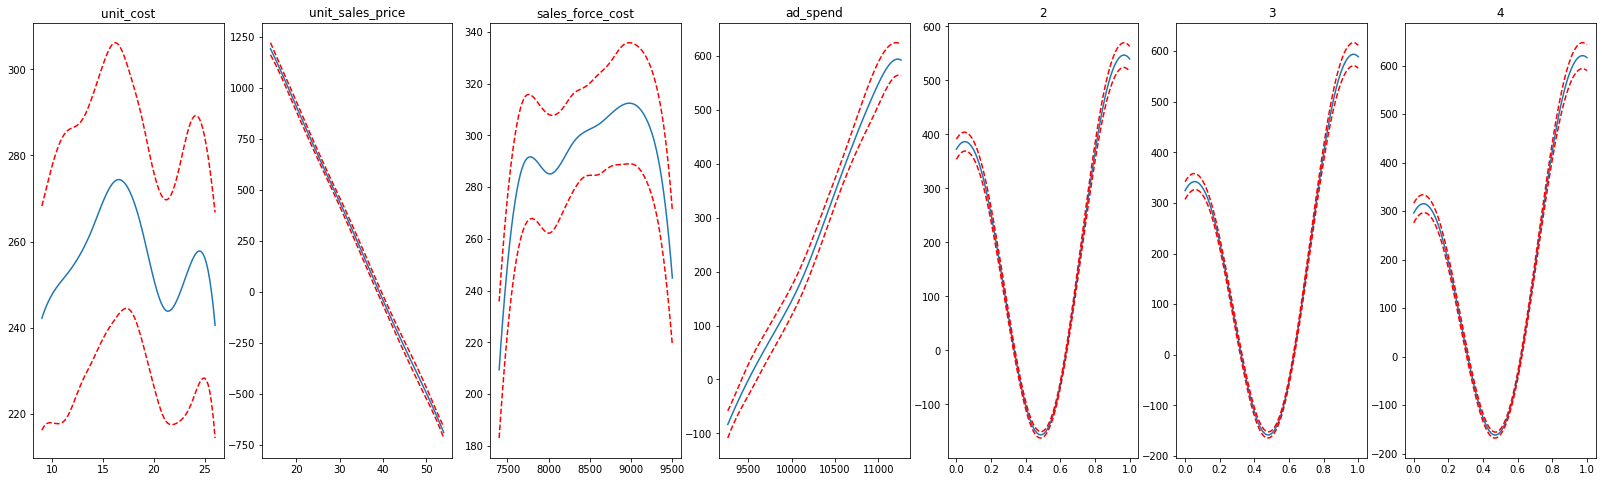

In [9]:
plt.figure()
plt.rcParams['figure.figsize'] = (28, 8)
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, 7)
titles = list(X_train.columns)
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
plt.show()

The graphs show that the unit_sales_price and ad_spend have approximately linear relationships with sales. However, the rest of the non-parametric functions show non-linearities. 

### 6. Test data validation.

In [10]:
# Predict the test data
y_pred = gam.predict(X_test)
def R2(y_test, y_pred):  
   return 1 - ((y_test - y_pred)**2).sum() / ((y_test - y_test.mean())**2).sum()  
def rmse(y_test, y_pred):  

   return sp.sqrt(sp.mean((y_test - y_pred) ** 2))


In [14]:
print(f"The Root Mean Square Error is: {rmse(y_test,y_pred)}")
print(f"The R-squared of the model in test data is: {R2(y_test,y_pred)}")

The Root Mean Square Error is: 48.489750498852736
The R-squared of the model in test data is: 0.9842455533340283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  import sys


Therefore, the model fitted to the test data has a RMSE of 48.49 and R-squared of 0.98, which has very high prediction power.

In [15]:
# Calculate prediction intervals
interval_array=gam.prediction_intervals(X_test, width=0.95, quantiles=None)
lower = [column[0] for column in interval_array]
higher = [column[1] for column in interval_array]

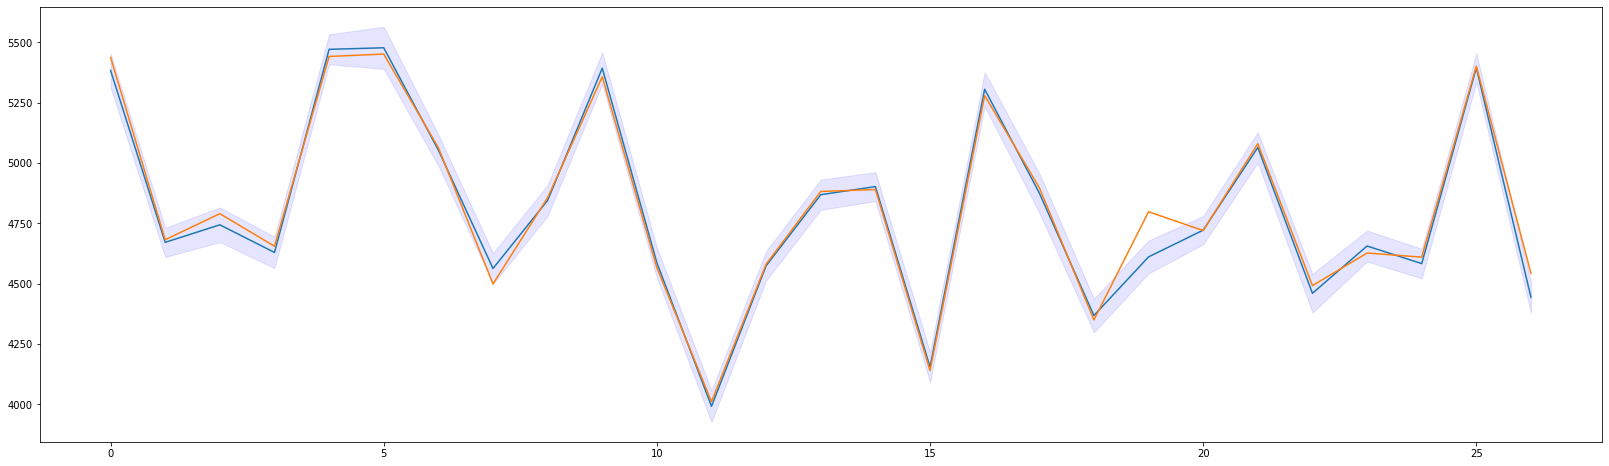

In [16]:
# Plot the actual values and predicted values with prediction intervals.
fig, ax = plt.subplots()
ax.plot(list(range(len(y_pred))),list(y_pred))
ax.plot(list(range(len(y_pred))),y_test.to_list())
ax.fill_between(list(range(len(y_pred))),lower,higher,color='b',alpha=.1)

### 7. Predict sales using ML formula

In [27]:
# Inputs
cost_per_unit = 25
sales_price_per_unit=40
seasonality=[1,2,3,4]
salesforce_cost=[8000,8000,9000,9000]
overhead_rate=0.15
k=35
b=3000
adv_spending=[10000]*4

In [28]:
# Sales forecasting
unit_cost = [cost_per_unit]*len(seasonality)
unit_sales_price=[sales_price_per_unit]*len(seasonality)
df_prediction = pd.DataFrame(zip(seasonality,unit_cost,unit_sales_price,salesforce_cost,adv_spending),
                             columns=["seasonality","unit_cost","unit_sales_price","salesforce_cost","adv_spending"])
df2 = df_prediction.iloc[:,1:5]
dummies2 = pd.get_dummies(df_prediction['seasonality'], drop_first=True)
df_pred = pd.concat([df2, dummies], axis = 1).head(len(seasonality))
df_pred

,unit_cost,unit_sales_price,salesforce_cost,adv_spending,2,3,4
0,25.0,40.0,8000.0,10000.0,0,0,0
1,25.0,40.0,8000.0,10000.0,1,0,0
2,25.0,40.0,9000.0,10000.0,0,1,0
3,25.0,40.0,9000.0,10000.0,0,0,1


In [29]:
df_pred['sales_pred'] = gam.predict(df_pred)
pred_sales = df_pred['sales_pred'].to_list()

In [30]:
pred_sales

[4046.3921533878956, 4213.613331555135, 4337.7143130110635, 4393.9752507163785]

In [31]:
# Gross profit calculations
COGS = [cost_per_unit*pred_sales[i] for i in range(len(seasonality))]
Sales_rev = [sales_price_per_unit*pred_sales[i] for i in range(len(seasonality))]
Gross_profit = [Sales_rev[i]-COGS[i] for i in range(len(seasonality))]
Annual_Gross_Profit = sum(Gross_profit)
Annual_Gross_Profit

254875.42573005712

In [32]:
# Operating expenses calculations
overhead=[Sales_rev[i]*overhead_rate for i in range(len(seasonality))]
Operating_expenses=[overhead[i]+salesforce_cost[i]+adv_spending[i] for i in range(len(seasonality))]
Annual_Operating_Cost=sum(Operating_expenses)
Annual_Operating_Cost

175950.17029202284

In [33]:
# Annual Operating Profit
Annual_Operating_Profit = Annual_Gross_Profit - Annual_Operating_Cost

### 8. Wrap up all the steps into a function

In [34]:
# Wrap into a function:
def cal_annual_profit(cost_per_unit = 25,
                      sales_price_per_unit=40,
                      seasonality=[1,2,3,4],
                      salesforce_cost=[8000,8000,9000,9000],
                      overhead_rate=0.15,
                      adv_spending=[10000]*len(seasonality)):
  # Sales forecasting
  unit_cost = [cost_per_unit]*len(seasonality)
  unit_sales_price=[sales_price_per_unit]*len(seasonality)
  df_prediction = pd.DataFrame(zip(seasonality,unit_cost,unit_sales_price,salesforce_cost,adv_spending),
                             columns=["seasonality","unit_cost","unit_sales_price","salesforce_cost","adv_spending"])
  df2 = df_prediction.iloc[:,1:5]
  dummies2 = pd.get_dummies(df_prediction['seasonality'], drop_first=True)
  df_pred = pd.concat([df2, dummies], axis = 1).head(len(seasonality))
  df_pred['sales_pred'] = gam.predict(df_pred)
  pred_sales = df_pred['sales_pred'].to_list()

  # Gross profit calculations
  COGS = [cost_per_unit*pred_sales[i] for i in range(len(seasonality))]
  Sales_rev = [sales_price_per_unit*pred_sales[i] for i in range(len(seasonality))]
  Gross_profit = [Sales_rev[i]-COGS[i] for i in range(len(seasonality))]
  Annual_Gross_Profit = sum(Gross_profit)
  Annual_Gross_Profit

  # Operating expenses calculations
  overhead=[Sales_rev[i]*overhead_rate for i in range(len(seasonality))]
  Operating_expenses=[overhead[i]+salesforce_cost[i]+adv_spending[i] for i in range(len(seasonality))]
  Annual_Operating_Cost=sum(Operating_expenses)
  Annual_Operating_Cost

  # Annual Operating Profit
  Annual_Operating_Profit = Annual_Gross_Profit - Annual_Operating_Cost
  print(f"The annual operating profit based on predicted sales is: {Annual_Operating_Profit}")


In [35]:
cal_annual_profit()

The annual operating profit based on predicted sales is: 78925.25543803428
